In [1]:
import h5py
import hdf5plugin
import numpy as np
from bblib.methods import CenterOfMass, FriedelPairs, MinimizePeakFWHM, CircleDetection
from bblib.models import PF8Info, PF8
from bblib.utils import visualize_single_panel
import fabio
import matplotlib.pyplot as plt
import om.lib.geometry as geometry

> Set here the absolute path to bblib_tutorial

In [2]:
tutorial_path="/path/to/bblib_tutorial"

> You will need to set the tutorial_path on the mask_file parameter in the geometry files cointaned in the bblib_tutorial/geoms folder

# Circle detection centering

In [3]:
config = {
    "plots_flag": True,
	"pf8": {
		"max_num_peaks": 10000,
		"adc_threshold": 10,
		"minimum_snr": 5,
		"min_pixel_count": 2,
		"max_pixel_count": 200,
		"local_bg_radius": 3,
		"min_res": 0,
		"max_res": 1200
		},
	"offset": {
		"x": 0.5,
		"y": 0.5
		},
	"peak_region":{
		"min": 60,
		"max": 80
		},
	"canny":{
		"sigma": 3,
		"low_threshold": 0.9,
		"high_threshold": 0.99
		},	
	"bragg_peaks_positions_for_center_of_mass_calculation": 0,
	"pixels_for_mask_of_bragg_peaks": 2,
	"polarization": {
		"apply_polarization_correction":True,
		"axis":"x",
		"value":0.99
		}
}

In [4]:
PF8Config=PF8Info(
        max_num_peaks=config["pf8"]["max_num_peaks"],
        adc_threshold=config["pf8"]["adc_threshold"],
        minimum_snr=config["pf8"]["minimum_snr"],
        min_pixel_count=config["pf8"]["min_pixel_count"],
        max_pixel_count=config["pf8"]["max_pixel_count"],
        local_bg_radius=config["pf8"]["local_bg_radius"],
        min_res=config["pf8"]["min_res"],
        max_res=config["pf8"]["max_res"]
    )

> First, open your raw file:

In [5]:
hdf5_file=f"{tutorial_path}/data/lyso_test_data_000014.h5"
f = h5py.File(hdf5_file, "r")
data = np.array(f["entry/data/data"][2], dtype=np.int32)
f.close()

Indicate the geometry filename that describes the initial detector geometry according to CrystFEL:

In [6]:
geometry_filename=f"{tutorial_path}/geoms/eiger500k.geom"

If you want to check and have a look how the data looks like:

In [7]:
hdf5_file=f"{tutorial_path}/masks/mask_lyso_test_data_000014.h5"
f = h5py.File(hdf5_file, "r")
mask = np.array(f["data/data"])
f.close()

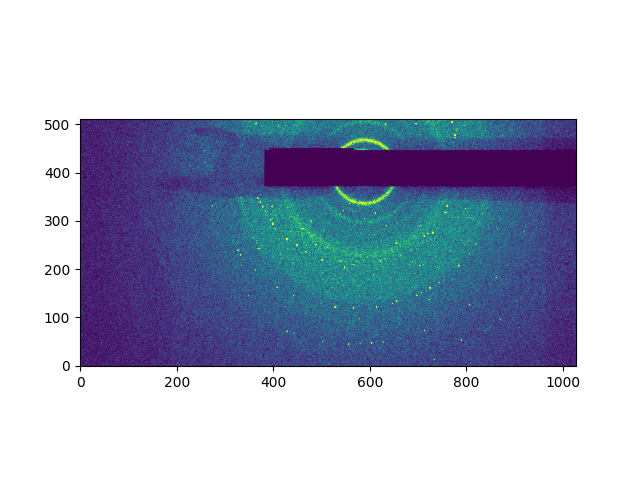

In [8]:
plt.close()
%matplotlib widget
plt.imshow(data*mask, vmin=0,vmax=10, origin="lower")
plt.show()

## Set detector geometry

In [9]:
PF8Config.set_geometry_from_file(geometry_filename)

> Visualize multi panels detector

In [10]:
# Not the case here, so I am commenting this
#data_visualize = geometry.DataVisualizer(pixel_maps=PF8Config.pixel_maps)
#visual_data = data_visualize.visualize_data(data=data * mask)
#plt.close()
#%matplotlib widget
#plt.imshow(visual_data, vmin=0, vmax=10, origin="lower")

> Visualize single panel detector

In [11]:
visual_data = visualize_single_panel(data*mask, PF8Config.transformation_matrix, PF8Config.ss_in_rows)

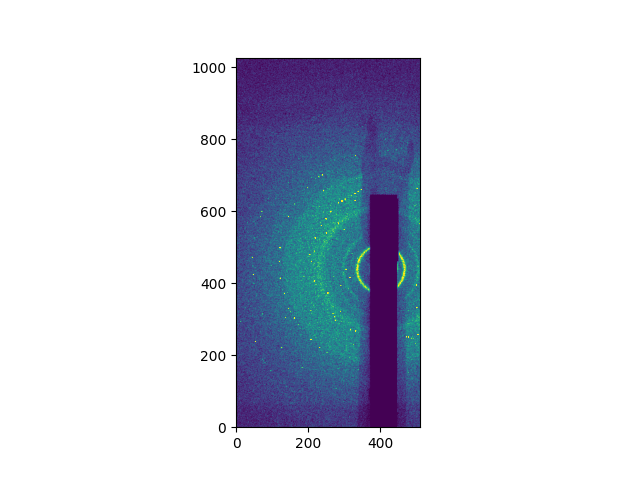

In [12]:
plt.close()
%matplotlib widget
plt.imshow(visual_data, vmin=0, vmax=10, origin="lower")

## Run the centering

> Dictionaries config and PF8Config ready for centering:

If you want to save intermediate steps plots, set the path as root_path/run_label/*/file_label_frame_index.png

In [13]:
plots_info={
	"file_name": "lyso_2",
	"folder_name": "beam_sweeping_lyso",
	"root_path": f"{tutorial_path}",
    "value_auto": True,
    "axis_lim_auto": True,
    "color_map": "viridis"
}

In [14]:
circle_detection_method = CircleDetection(
                        config=config, PF8Config=PF8Config, plots_info=plots_info
                    )

In [15]:
center_coordinates_from_circle_detection = circle_detection_method(
                        data = data
                    )

> Print the final result:

In [16]:
center_coordinates_from_circle_detection

[401.5, 438.5]

In [17]:
PF8Config.detector_center_from_geom

[401, 370]

In [18]:
beam_position_shift = [center_coordinates_from_circle_detection[x] - PF8Config.detector_center_from_geom[x] for x in range(2)]

In [19]:
detector_shift_in_mm = [np.round(-1 * x *1e3 / PF8Config.pixel_resolution, 4) for x in beam_position_shift]

In [20]:
detector_shift_in_mm

[-0.0375, -5.1375]

# Friedel Pairs centering

In [21]:
config = {
    "plots_flag": True,
	"search_radius": 4,
	"pf8": {
		"max_num_peaks": 10000,
		"adc_threshold": 10,
		"minimum_snr": 5,
		"min_pixel_count": 2,
		"max_pixel_count": 200,
		"local_bg_radius": 3,
		"min_res": 0,
		"max_res": 1200
		},
	"offset": {
		"x": 0.5,
		"y": 0.5
		},
	"polarization": {
		"apply_polarization_correction": True,
		"axis":"x",
		"value":0.99
		}
}

In [22]:
PF8Config=PF8Info(
        max_num_peaks=config["pf8"]["max_num_peaks"],
        adc_threshold=config["pf8"]["adc_threshold"],
        minimum_snr=config["pf8"]["minimum_snr"],
        min_pixel_count=config["pf8"]["min_pixel_count"],
        max_pixel_count=config["pf8"]["max_pixel_count"],
        local_bg_radius=config["pf8"]["local_bg_radius"],
        min_res=config["pf8"]["min_res"],
        max_res=config["pf8"]["max_res"]
    )

> First, open your raw file:

In [23]:
hdf5_file=f"{tutorial_path}/data/lyso_test_data_000014.h5"
f = h5py.File(hdf5_file, "r")
data = np.array(f["entry/data/data"][2], dtype=np.int32)
f.close()

> Indicate the geometry filename that describes the initial detector geometry according to CrystFEL:

In [24]:
geometry_filename=f"{tutorial_path}/geoms/eiger500k.geom"

If you want to check and have a look how the data looks like:

In [25]:
hdf5_file=f"{tutorial_path}/masks/mask_lyso_test_data_000014.h5"
f = h5py.File(hdf5_file, "r")
mask = np.array(f["data/data"])
f.close()

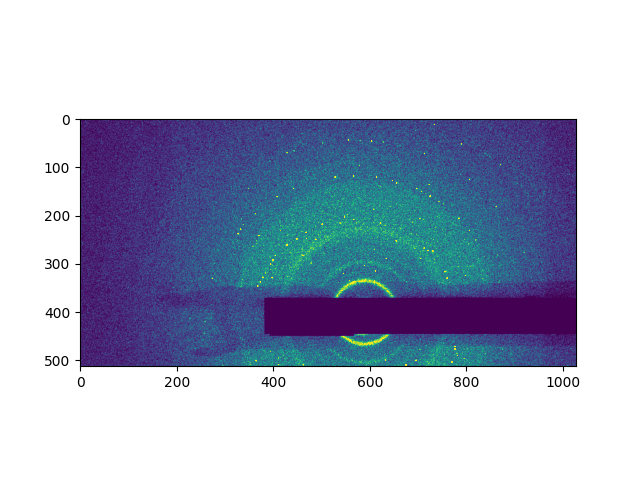

In [26]:
%matplotlib widget
plt.imshow(data*mask, vmin=0,vmax=10)
plt.show()

## Set detector geometry

In [27]:
PF8Config.set_geometry_from_file(geometry_filename)

> Visualize multi panels detector

In [28]:
# Not the case here, so I am commenting this
#data_visualize = geometry.DataVisualizer(pixel_maps=PF8Config.pixel_maps)
#visual_data = data_visualize.visualize_data(data=data * mask)
#plt.close()
#%matplotlib widget
#plt.imshow(visual_data, vmin=0, vmax=10, origin="lower")

> Visualize single panel detector

In [29]:
visual_data = visualize_single_panel(data*mask, PF8Config.transformation_matrix, PF8Config.ss_in_rows)

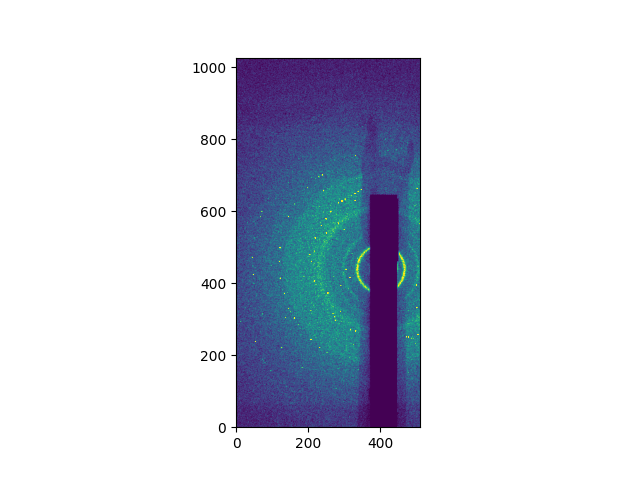

In [30]:
plt.close()
%matplotlib widget
plt.imshow(visual_data, vmin=0, vmax=10, origin="lower")

## Run the centering

Dictionaries config and PF8Config ready for centering:

For the FriedelPairs method an initial_guess need to be passed, set here the coordinates in x and y of the initial guess for the center after setting the detector geometry:

In [31]:
initial_guess=[402,440]

If you want to save intermediate steps plots, set the path as root_path/run_label/*/file_label_frame_index.png

In [32]:
plots_info={
	"file_name": "lyso_2",
	"folder_name": "beam_sweeping_lyso",
	"root_path": f"{tutorial_path}",
    "value_auto": True,
    "axis_lim_auto": True,
    "color_map": "viridis"
}

In [33]:
friedel_pairs_method = FriedelPairs(
                        config=config, PF8Config=PF8Config, plots_info=plots_info
                    )

In [34]:
center_coordinates_from_friedel_pairs = friedel_pairs_method(
                        data = data, initial_guess= initial_guess
                    )

--------------  Friedel pairs search --------------
Number of Friedel Pairs in frame: 1.0
Pairs list for analysis:
[((-73.5, 188.5), (-74.5, 190.5)), ((74.5, -190.5), (73.5, -188.5))]
Friedel pairs position before center correction in pixels:
[(-73.5, 188.5), (74.5, -190.5)]
Center shift in x 1.0
Center shift in y -0.5
Friedel pairs position after center correction in pixels:
[(-74.5, 189.0), (73.5, -190.0)]
All reflections after center correction in pixels:
[(-391.5, -147.0), (-358.5, 31.0), (-357.5, 7.0), (-355.5, -17.0), (-354.5, -41.0), (-352.5, 85.0), (-350.5, -203.0), (-336.5, 144.0), (-332.5, 158.0), (-330.5, -126.0), (-308.5, -284.0), (-287.5, -201.0), (-284.5, 20.0), (-281.5, 58.0), (-281.5, -27.0), (-277.5, -220.0), (-274.5, -60.0), (-269.5, -69.0), (-258.5, 145.0), (-258.5, -111.0), (-242.5, -138.0), (-241.5, 179.0), (-231.5, -157.0), (-221.5, -275.0), (-216.5, -22.0), (-206.5, 224.0), (-199.5, 39.0), (-196.5, -117.0), (-196.5, -197.0), (-186.5, 49.0), (-186.5, -35.0), (-184

> Print the final result:

In [35]:
center_coordinates_from_friedel_pairs

[403.0, 439.5]

In [36]:
PF8Config.detector_center_from_geom

[401, 370]

In [37]:
beam_position_shift = [center_coordinates_from_friedel_pairs[x] - PF8Config.detector_center_from_geom[x] for x in range(2)]

In [38]:
beam_position_shift

[2.0, 69.5]

In [39]:
detector_shift_in_mm = [np.round(-1 * x *1e3 / PF8Config.pixel_resolution, 4) for x in beam_position_shift]

In [40]:
detector_shift_in_mm

[-0.15, -5.2125]

# Center of mass centering

In [41]:
config = {
    "plots_flag": True,
	"pf8": {
		"max_num_peaks": 10000,
		"adc_threshold": 10,
		"minimum_snr": 5,
		"min_pixel_count": 2,
		"max_pixel_count": 200,
		"local_bg_radius": 3,
		"min_res": 0,
		"max_res": 1200
		},
	"offset": {
		"x": 0.5,
		"y": 0.5
		},
	"bragg_peaks_positions_for_center_of_mass_calculation": 0,
	"pixels_for_mask_of_bragg_peaks": 2,
	"polarization": {
		"apply_polarization_correction": True,
		"axis":"x",
		"value":0.99
		}
}

In [42]:
PF8Config=PF8Info(
        max_num_peaks=config["pf8"]["max_num_peaks"],
        adc_threshold=config["pf8"]["adc_threshold"],
        minimum_snr=config["pf8"]["minimum_snr"],
        min_pixel_count=config["pf8"]["min_pixel_count"],
        max_pixel_count=config["pf8"]["max_pixel_count"],
        local_bg_radius=config["pf8"]["local_bg_radius"],
        min_res=config["pf8"]["min_res"],
        max_res=config["pf8"]["max_res"]
    )

> First, open your raw file:

In [43]:
cbf_file=f"{tutorial_path}/data/chipD_001_00111.cbf"
data = fabio.open(cbf_file).data

Indicate the geometry filename that describes the initial detector geometry according to CrystFEL:

In [44]:
geometry_filename=f"{tutorial_path}/geoms/pilatus6M.geom"

If you want to check and have a look how the data looks like:

In [45]:
hdf5_file=f"{tutorial_path}/masks/mask_chipD_001_00111.h5"
f = h5py.File(hdf5_file, "r")
mask = np.array(f["data/data"])
f.close()

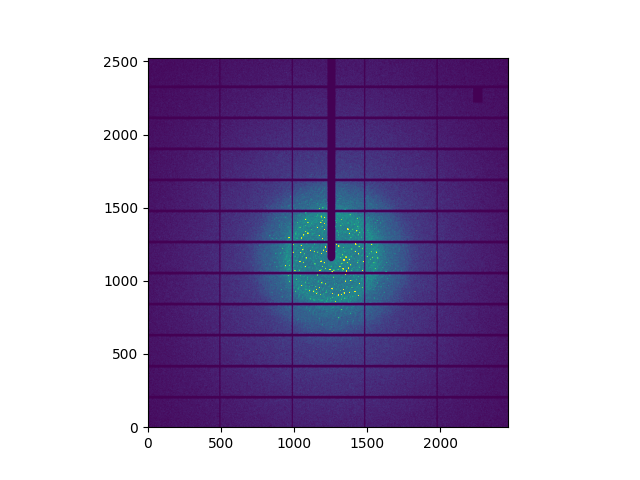

In [46]:
plt.close()
%matplotlib widget
plt.imshow(data*mask, vmin=0,vmax=10, origin="lower")
plt.show()

## Set detector geometry

In [47]:
PF8Config.set_geometry_from_file(geometry_filename)

>  Visualize multi panels detector

In [48]:
# Not the case here, so I am commenting this
#data_visualize = geometry.DataVisualizer(pixel_maps=PF8Config.pixel_maps)
#visual_data = data_visualize.visualize_data(data=data * mask)
#plt.close()
#%matplotlib widget
#plt.imshow(visual_data, vmin=0, vmax=10, origin="lower")

>  Visualize single panel detector

In [49]:
visual_data = visualize_single_panel(data*mask, PF8Config.transformation_matrix, PF8Config.ss_in_rows)

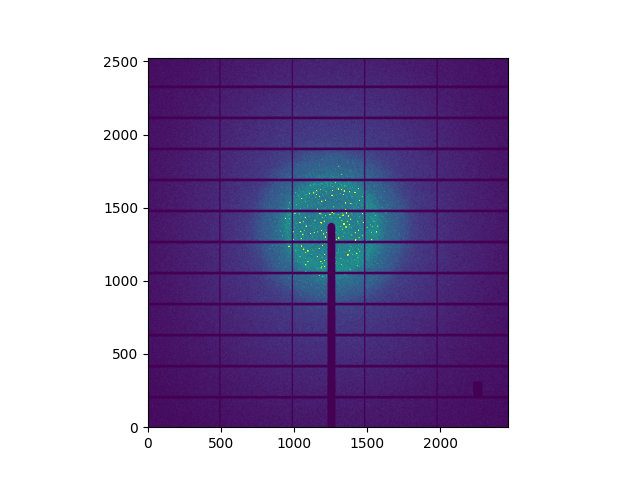

In [50]:
plt.close()
%matplotlib widget
plt.imshow(visual_data, vmin=0, vmax=10, origin="lower")

## Run the centering

> Dictionaries config and PF8Config ready for centering:

If you want to save intermediate steps plots, set the path as root_path/run_label/*/file_label_frame_index.png

In [51]:
plots_info={
	"file_name": "chip_D_111",
	"folder_name": "fakp",
	"root_path": f"{tutorial_path}",
    "value_auto": True,
    "axis_lim_auto": True,
    "color_map": "viridis"
}

In [52]:
center_of_mass_method = CenterOfMass(
                        config=config, PF8Config=PF8Config, plots_info=plots_info
                    )

In [53]:
center_coordinates_from_center_of_mass = center_of_mass_method(
                        data = data
                    )

> Print the final result:

In [54]:
center_coordinates_from_center_of_mass

array([1250., 1338.])

In [55]:
PF8Config.detector_center_from_geom

[1252, 1349]

In [56]:
beam_position_shift = [center_coordinates_from_center_of_mass[x] - PF8Config.detector_center_from_geom[x] for x in range(2)]

In [57]:
detector_shift_in_mm = [np.round(-1 * x *1e3 / PF8Config.pixel_resolution, 4) for x in beam_position_shift]

In [58]:
detector_shift_in_mm

[0.344, 1.892]

# Minimize peak FWHM

In [59]:
config = {
    "plots_flag": True,
	"pf8": {
		"max_num_peaks": 10000,
		"adc_threshold": 10,
		"minimum_snr": 5,
		"min_pixel_count": 2,
		"max_pixel_count": 200,
		"local_bg_radius": 3,
		"min_res": 0,
		"max_res": 1200
		},
	"offset": {
		"x": 0.5,
		"y": 0.5
		},
	"peak_region":{
		"min": 200,
		"max": 400
		},
	"bragg_peaks_positions_for_center_of_mass_calculation": 0,
	"pixels_for_mask_of_bragg_peaks": 2,
	"polarization": {
		"apply_polarization_correction":True,
		"axis":"x",
		"value":0.99
		}
}

In [60]:
PF8Config=PF8Info(
        max_num_peaks=config["pf8"]["max_num_peaks"],
        adc_threshold=config["pf8"]["adc_threshold"],
        minimum_snr=config["pf8"]["minimum_snr"],
        min_pixel_count=config["pf8"]["min_pixel_count"],
        max_pixel_count=config["pf8"]["max_pixel_count"],
        local_bg_radius=config["pf8"]["local_bg_radius"],
        min_res=config["pf8"]["min_res"],
        max_res=config["pf8"]["max_res"]
    )

> First, open your raw file:

In [61]:
cbf_file=f"{tutorial_path}/data/chipD_001_00111.cbf"
data = fabio.open(cbf_file).data

Indicate the geometry filename that describes the initial detector geometry according to CrystFEL:

In [62]:
geometry_filename=f"{tutorial_path}/geoms/pilatus6M.geom"

If you want to check and have a look how the data looks like:

In [63]:
hdf5_file=f"{tutorial_path}/masks/mask_chipD_001_00111.h5"
f = h5py.File(hdf5_file, "r")
mask = np.array(f["data/data"])
f.close()

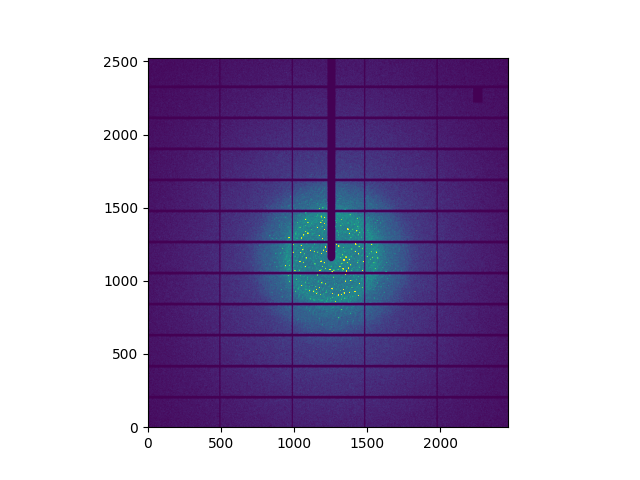

In [64]:
plt.close()
%matplotlib widget
plt.imshow(data*mask, vmin=0,vmax=10, origin="lower")
plt.show()

## Set detector geometry

In [65]:
PF8Config.set_geometry_from_file(geometry_filename)

>  Visualize multi panels detector

In [66]:
# Not the case here, so I am commenting this
#data_visualize = geometry.DataVisualizer(pixel_maps=PF8Config.pixel_maps)
#visual_data = data_visualize.visualize_data(data=data * mask)
#plt.close()
#%matplotlib widget
#plt.imshow(visual_data, vmin=0, vmax=10, origin="lower")

>  Visualize single panel detector

In [67]:
visual_data = visualize_single_panel(data*mask, PF8Config.transformation_matrix, PF8Config.ss_in_rows)

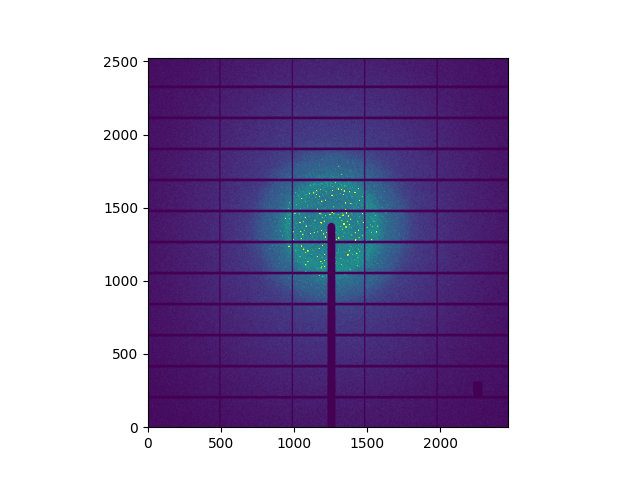

In [68]:
plt.close()
%matplotlib widget
plt.imshow(visual_data, vmin=0, vmax=10, origin="lower")

## Run the centering

> Dictionaries config and PF8Config ready for centering:

For the MinimizePeakFWHM method an initial_guess need to be passed, set here the coordinates in x and y of the initial guess for the center after setting the detector geometry:

In [69]:
initial_guess=[1255,1355]

If you want to save intermediate steps plots, set the path as root_path/run_label/*/file_label_frame_index.png

In [70]:
plots_info={
	"file_name": "chip_D_111",
	"folder_name": "fakp",
	"root_path": f"{tutorial_path}",
    "value_auto": True,
    "axis_lim_auto": True,
    "color_map": "viridis"
}

In [71]:
minimize_peak_fwhm_method = MinimizePeakFWHM(
                        config=config, PF8Config=PF8Config, plots_info=plots_info
                    )

**Warning** 

Method not optmized, computationally yet, this might take a while. In the future, it might have a better version for this method

In [72]:
center_coordinates_from_minimize_peak_fwhm = minimize_peak_fwhm_method(
                        data = data, initial_guess=initial_guess
                    )

> Print the final result:

In [73]:
center_coordinates_from_minimize_peak_fwhm

[1249.5, 1372.5]

In [74]:
PF8Config.detector_center_from_geom

[1252, 1349]

In [75]:
beam_position_shift = [center_coordinates_from_minimize_peak_fwhm[x] - PF8Config.detector_center_from_geom[x] for x in range(2)]

In [76]:
detector_shift_in_mm = [np.round(-1 * x *1e3 / PF8Config.pixel_resolution, 4) for x in beam_position_shift]

In [77]:
detector_shift_in_mm

[0.43, -4.042]